# Capstone Project 1 - EDA
## Name: Brock Nosbisch

#### Summary:
This is a continuation from the "Capstone Project 1 - Data Wrangling" and "Capstone Project 1 - Data Story" notebooks.  The data from the "Data Wrangling" notebooks was written to the data_wrangling_out.csv file which is read into the Capstone Project 1 - Data Story notebook and that notebook is imported into this EDA notebook. 

The problem I am trying to solve is to predict the probability of someone defaulting on payment (>90 days late).  The end goal is to emphasize on several algorithms and review the performance and strengths and weaknesses of each.  The dataset being used contains data as of the time of applying for a loan.  The Past Due fields contain data on the loan applicant for the prior 2 years.  For example, if I am applying for a loan today, my Age, Unsecured Lines, Debt Ratio, etc. are as of the applicant date and the Past Due fields would have data for the past 2 previous years.  The Serious Delinquent fields, which is what we are trying to predict, has a 1 if that person became delinquent (default) in the 2 years after applying for a loan and a 0 if they did not become delinquent in those 2 years.

After doing EDA, there are several correlations that are of statistical significance and a few that have practical signficance.

First I am comparing the Pearson correlation between each Past Due Bucket and Serious Delinquent; each has statistical and practical signficance.  And when looking at the correlation for Age and Open Credit Lines correlation to Serious Delinquency, each is of statistical significance but each has an r^2 less than 1% so they are of no practical significance.  

I've also included a Heatmap of all Correlations using Spearman method.

Based on the Bootstrap Estimate of Serious Delinquent Average, the 95% confidence interval of the entire dataset to be Seriously Delinquent is from 6.47% to 6.72%.

When using Logistic Regression (with no balancing), the Accuracy, Precision, Recall, and F1 Score look good for determining people that will not Default BUT my challenge is to determine those that will default.  The Confusion Matrix shows us that I am able to predict 671 out of the 3,946 actual defaults (~17%).  But out of the 1,101 predicted defaults, I was able to predict 671 of them which gives us a 60.9% prediction rate.  The F1 Score for determining defaults was 27%.

In addition, the average 10-fold CV Score was .937 and ROC AUC Score was .823.

So the Logistic Regression with no balancing was okay but didn't help our cause much.  When using Logistic Regression with Balancing, the Confusion Matrix is showing 98.4% accuracy, 97% precision, 85% recall, and 91% F1 score.  But since the weighting was balanced (n_samples / (n_classes * np.bincount(y))), the model predicted a total of 11,004 Defaults and 2,587 of those were actual Defaults. The total actual count of Defaults was 3,946 which means the model predicted 65% of all defaults.  Even though 15% of the total non-defaulters are mistakingly predicted to default, being able to predict that 65% of all defaults is better financially since defaulters cost a company much more than a non-defaulter.

I used Lasso for Feature Selection and the results were not obvious at first because I had to reduce alpha to .001 to get good features.  As expected, the features chosen are the Past Due Flags.  



# Load Data

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from scipy import stats
# from statsmodels.nonparametric.kernel_regression import KernelReg

from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score


In [64]:
# Import my data story notebook.
import import_ipynb
import Chapter_2_Capstone_1_Data_Story as ds

### Functions

In [65]:
def pearsonr_ci(x,y,alpha=0.05):

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    low_z, high_z = r_z-z*se, r_z+z*se
    low, high = np.tanh((low_z, high_z))
    return r, p, low, high

# Bootstrap Replicates	
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))


# Exploratory Data Analysis

## Pearson Correlation
### We can see that based on the Pearson Correlation, Serious Delinquency has a higher r value when correlated with the Past Due buckets.  r keeps getting larger as you go from 30-59 days, 60-89 days, and 90+ days.

In [66]:
df = ds.df
df.corr(method='pearson')

,age,age_bucket,debt_ratio,debt_ratio_bucket,debt_ratio_name,monthly_income,monthly_income_bucket,past_due_30_59,past_due_30_59_flag,past_due_60_89,past_due_60_89_flag,past_due_90_plus,past_due_90_plus_flag,open_credit_lines,serious_delinquent,unsecured_lines,real_estate_loans,number_of_dependents
age,1.000000,0.981561,0.023857,0.022142,0.041563,0.037341,-0.056543,-0.071845,-0.089553,-0.069854,-0.076682,-0.082392,-0.096198,0.144742,-0.112979,-0.005955,0.031280,-0.217236
age_bucket,0.981561,1.000000,0.022767,0.021549,0.040640,0.037002,-0.055498,-0.070543,-0.088541,-0.067922,-0.075004,-0.080673,-0.094615,0.141598,-0.110557,-0.006499,0.030593,-0.213977
debt_ratio,0.023857,0.022767,1.000000,0.264491,0.452315,-0.028737,-0.286322,0.003492,0.001497,-0.004196,-0.004713,-0.009848,-0.012922,0.049183,-0.007069,0.003955,0.119862,-0.044614
debt_ratio_bucket,0.022142,0.021549,0.264491,1.000000,0.524069,-0.074058,-0.584915,0.048546,0.040902,0.016900,0.010772,-0.012254,-0.022143,0.197305,0.023582,0.002711,0.335688,-0.051712
debt_ratio_name,0.041563,0.040640,0.452315,0.524069,1.000000,-0.039429,-0.553173,-0.003871,-0.009051,-0.010219,-0.012844,-0.018511,-0.024413,0.063643,-0.021686,0.005717,0.159920,-0.087950
monthly_income,0.037341,0.037002,-0.028737,-0.074058,-0.039429,1.000000,0.333253,-0.001914,-0.002578,-0.011535,-0.012378,-0.019882,-0.024018,0.091026,-0.019119,0.007118,0.124710,0.062511
monthly_income_bucket,-0.056543,-0.055498,-0.286322,-0.584915,-0.553173,0.333253,1.000000,0.036914,0.039262,-0.004973,-0.004789,-0.025380,-0.029278,0.234739,-0.007631,0.006365,0.223963,0.264030
past_due_30_59,-0.071845,-0.070543,0.003492,0.048546,-0.003871,-0.001914,0.036914,1.000000,0.812041,0.305879,0.300748,0.218149,0.256566,0.080073,0.274553,-0.002818,0.042756,0.065611
past_due_30_59_flag,-0.089553,-0.088541,0.001497,0.040902,-0.009051,-0.002578,0.039262,0.812041,1.000000,0.240420,0.251075,0.192123,0.227021,0.068947,0.241231,-0.002372,0.034909,0.071038
past_due_60_89,-0.069854,-0.067922,-0.004196,0.016900,-0.010219,-0.011535,-0.004973,0.305879,0.240420,1.000000,0.865304,0.294638,0.298305,-0.021907,0.268130,-0.002441,-0.020695,0.037633


### Setup an appropriate hypothesis test.
* Null Hypothesis: There is no significant correlation between Serious Delinquency and Past Due By Days.
* Alternative Hypothesis: There is a significant correlation between Serious Delinquency and Past Due By Days.

### As expected, the below shows the that the Past Due Flags are correlated with the Serious Delinquent Flag.  As the Past Due Days get larger, (from 30-59, 60-89, 90+ days), the r^2 value gets larger with the 90+ Days having r^2 of .33.
### We can, without a doubt, reject the Null Hypothesis.
    

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149730 entries, 1 to 150000
Data columns (total 20 columns):
age                      149730 non-null int64
age_bucket               149730 non-null float64
age_bucket_name          149730 non-null object
debt_ratio               149730 non-null float64
debt_ratio_bucket        149730 non-null float64
debt_ratio_name          149730 non-null float64
monthly_income           120120 non-null float64
monthly_income_bucket    149730 non-null int64
monthly_income_name      149730 non-null object
past_due_30_59           149730 non-null int64
past_due_30_59_flag      149730 non-null float64
past_due_60_89           149730 non-null int64
past_due_60_89_flag      149730 non-null float64
past_due_90_plus         149730 non-null int64
past_due_90_plus_flag    149730 non-null float64
open_credit_lines        149730 non-null int64
serious_delinquent       149730 non-null int64
unsecured_lines          149730 non-null float64
real_estate_loans      

In [68]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['past_due_30_59_flag'], y=df['serious_delinquent'], alpha=.05)

print('Dependent: Serious Delinquent Flag')
print('Independent: Past Due 30-59 Days')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Serious Delinquent Flag
Independent: Past Due 30-59 Days
p-value: 0.0
r: 0.24123095914912063
r^2: 0.058192375652004705
CI: 0.2364547042508215 to 0.24599555630325018


In [69]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['past_due_60_89_flag'], y=df['serious_delinquent'], alpha=.05)

print('Dependent: Serious Delinquent Flag')
print('Independent: Past Due 60-89 Days')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Serious Delinquent Flag
Independent: Past Due 60-89 Days
p-value: 0.0
r: 0.26661967500852773
r^2: 0.07108605110165295
CI: 0.2619082020802465 to 0.27131843964736596


In [70]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['past_due_90_plus_flag'], y=df['serious_delinquent'], alpha=.05)

print('Dependent: Serious Delinquent Flag')
print('Independent: Past Due 90+ Days')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Serious Delinquent Flag
Independent: Past Due 90+ Days
p-value: 0.0
r: 0.3327330719621715
r^2: 0.1107112971773836
CI: 0.328221066189084 to 0.3372298946998459


### Setup an appropriate hypothesis test.
* Null Hypothesis: There is no significant correlation between Serious Delinquency and Age Buckets or Open Credit Lines.
* Alternative Hypothesis: There is a significant correlation between Serious Delinquency and Age Buckets or Open Credit Lines.

### The below shows the Age Buckets and Open Credit Lines correlation to the Serious Delinquent Flag.  All have a p-value < .05 so there is a statistical significance in the correlations and it shows that there is little practical significance since all r^2 values are small (<=.1%).  But we do intuitively know that the Past Due by Age Bucket does have a negative r which confirms what has already been stated in that the younger you are, the higher chance you have of defaulting.


In [71]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['age_bucket'], y=df['serious_delinquent'], alpha=.05)

print('Dependent: Serious Delinquent Flag')
print('Independent: Age Bucket')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Serious Delinquent Flag
Independent: Age Bucket
p-value: 0.0
r: -0.11055744235874816
r^2: 0.012222948060907922
CI: -0.11555790416186493 to -0.1055513769743192


In [72]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['open_credit_lines'], y=df['serious_delinquent'], alpha=.05)

print('Dependent: Serious Delinquent Flag')
print('Independent: Open Credit Lines')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Serious Delinquent Flag
Independent: Open Credit Lines
p-value: 6.7314043367713414e-21
r: -0.024232041465668614
r^2: 0.0005871918335938831
CI: -0.02929361935761476 to -0.019169220910207563


### And again confirming the above and looking at the past due flags, viewing Age by Past Due shows there is a negative correlation.

In [73]:
df[['age','past_due_30_59_flag','past_due_60_89_flag','past_due_90_plus_flag','serious_delinquent']].corr(method='pearson')

,age,past_due_30_59_flag,past_due_60_89_flag,past_due_90_plus_flag,serious_delinquent
age,1.000000,-0.089553,-0.076682,-0.096198,-0.112979
past_due_30_59_flag,-0.089553,1.000000,0.251075,0.227021,0.241231
past_due_60_89_flag,-0.076682,0.251075,1.000000,0.291705,0.266620
past_due_90_plus_flag,-0.096198,0.227021,0.291705,1.000000,0.332733
serious_delinquent,-0.112979,0.241231,0.266620,0.332733,1.000000


### To prove the above out, setup an appropriate hypothesis test.
* Null Hypothesis: There is no significant correlation between being Past Due and Age.
* Alternative Hypothesis: There is a significant correlation between being Past Due and Age.

### As expected, the below shows the that the Age is negatively correlated with the Past Due Flags.  

In [74]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['age'], y=df['past_due_30_59_flag'], alpha=.05)

print('Dependent: Past Due 30-59 Days')
print('Independent: Age')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Past Due 30-59 Days
Independent: Age
p-value: 3.663079671989339e-264
r: -0.08955314371262713
r^2: 0.008019765548814447
CI: -0.09457541747115 to -0.08452631165760664


In [75]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['age'], y=df['past_due_60_89_flag'], alpha=.05)

print('Dependent: Past Due 60-89 Days')
print('Independent: Age')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Past Due 60-89 Days
Independent: Age
p-value: 4.805295472034942e-194
r: -0.07668246205392479
r^2: 0.0058801999866516155
CI: -0.08171589616142474 to -0.07164511635519083


In [76]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['age'], y=df['past_due_90_plus_flag'], alpha=.05)

print('Dependent: Past Due 90+ Days')
print('Independent: Age')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Past Due 90+ Days
Independent: Age
p-value: 1.133477492273373e-304
r: -0.09619772796056858
r^2: 0.009254002864775557
CI: -0.10121358419059122 to -0.0911769813137903


In [77]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['age'], y=df['serious_delinquent'], alpha=.05)

print('Dependent: Serious Delinquent')
print('Independent: Age')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Dependent: Serious Delinquent
Independent: Age
p-value: 0.0
r: -0.11297879078283807
r^2: 0.012764207166752296
CI: -0.11797645128939278 to -0.10797540710711141


### Additional Hypothesis Tests
* Null Hypothesis: There is no significant correlation between the 2 independent variables.
* Alternative Hypothesis: There is a significant correlation between the 2 independent variables.

#### Each of the below tests are significant and reject the Null Hypothesis but this is expected.  


In [78]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['age'], y=df['open_credit_lines'], alpha=.05)

print('Independent: Open Credit Lines')
print('Independent: Age')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Independent: Open Credit Lines
Independent: Age
p-value: 0.0
r: 0.1447419640551312
r^2: 0.020950236158536893
CI: 0.1397792688917278 to 0.14969738781765551


In [79]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['real_estate_loans'], y=df['open_credit_lines'], alpha=.05)

print('Independent: Open Credit Lines')
print('Independent: Real Estate Loans')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Independent: Open Credit Lines
Independent: Real Estate Loans
p-value: 0.0
r: 0.43266866422509553
r^2: 0.18720217300232847
CI: 0.42854266000109265 to 0.43677662337419804


In [80]:
# Use Pearson calcuation to figure out p-value (also including r, r^2, ci)
r, p, low, high = pearsonr_ci(x=df['debt_ratio'], y=df['real_estate_loans'], alpha=.05)

print('Independent: Debt Ratio')
print('Independent: Real Estate Loans')
print('p-value: ' + str(p))
print('r: ' + str(r))
print('r^2: ' + str(r**2))
print('CI: ' + str(low) + ' to ' + str(high))

Independent: Debt Ratio
Independent: Real Estate Loans
p-value: 0.0
r: 0.11986204784290087
r^2: 0.014366910513093857
CI: 0.11486661252069078 to 0.12485142116758134


## Spearman Correlation using HeatMap

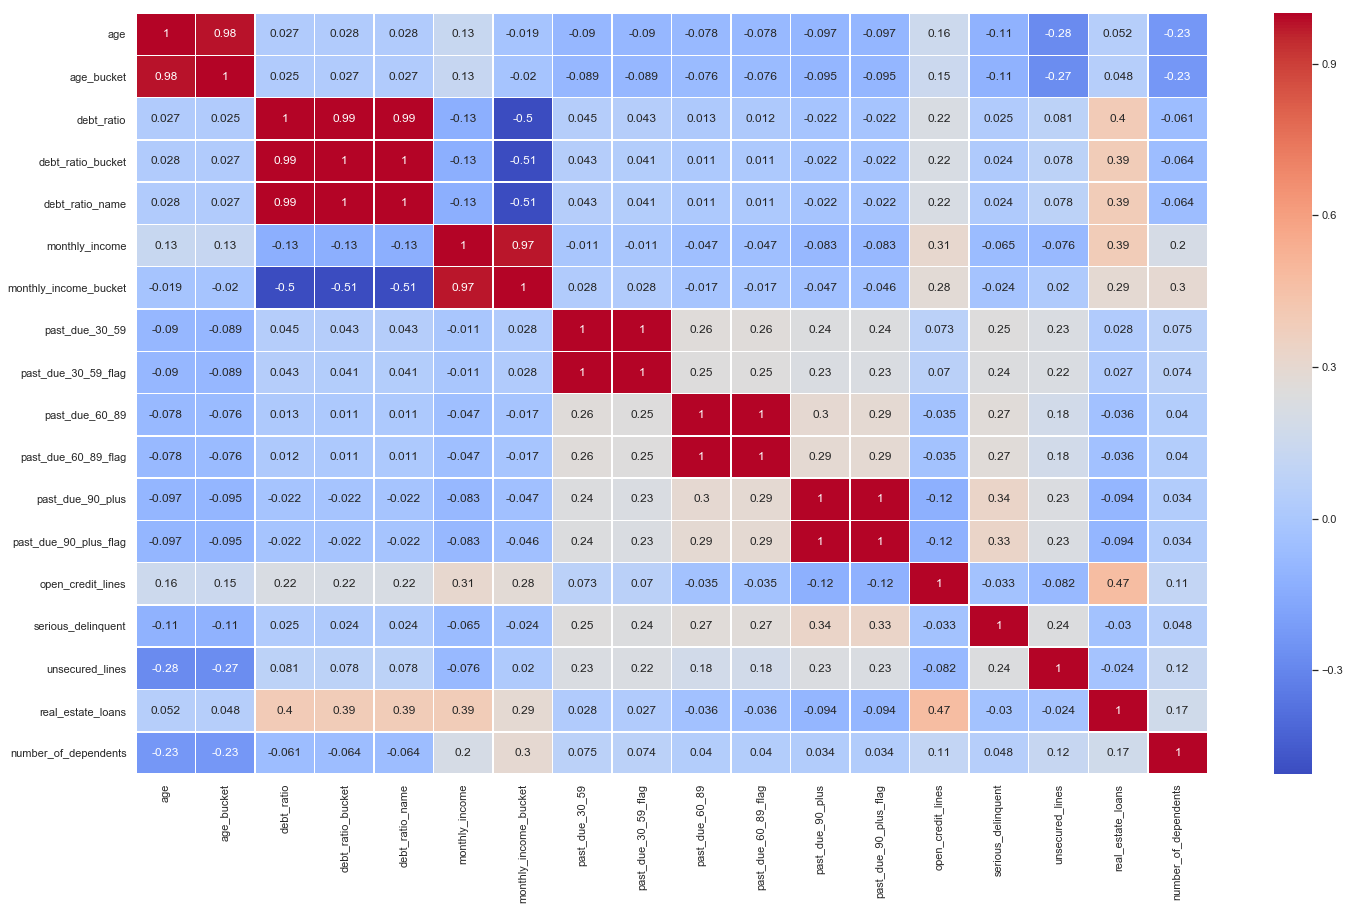

In [81]:

fig, ax = plt.subplots(figsize=(24,14))

sns.heatmap(df.corr(method='spearman'), annot=True, linewidth=.5, cmap='coolwarm')
#sns.heatmap(df, annot=labels, fmt="", cmap='RdYlGn', linewidths=.3, ax=ax)

plt.show()

## Bootstrap Estimate of Serious Delinquent Mean
### This is showing that overall, the 95% confidence interval for Seriously Delinquency is from 6.47% to 6.72%.

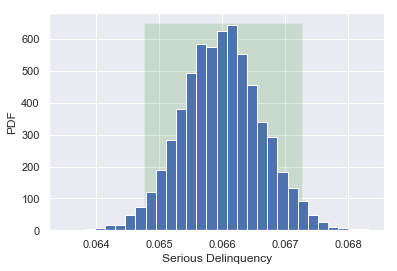


Bootstrap 95% Confidence Interval
[0.06474988 0.06726107]


In [82]:
bs_replicates = np.empty(10000)

for i in range(10000):
    bs_replicates[i] = bootstrap_replicate_1d(df['serious_delinquent'], np.mean)
    
_ = plt.hist(bs_replicates, bins=30, density=True)
_ = plt.xlabel('Serious Delinquency')
_ = plt.ylabel('PDF')
conf_int = np.percentile(bs_replicates, [2.5, 97.5])

plt.fill_between(conf_int, 0, 650, facecolor='green', alpha = .15, interpolate=True)

plt.show()

print()

print('Bootstrap 95% Confidence Interval')
print(conf_int)

## Logistic Regression
### The Confusion Matrix is showing the below which looks good:
* Accuracy was 93.8% (56,187 out of 59,892)
* Precision was 94.5%
* Recall was 99.2%
* F1 Score is 96.8%

### But if I look at how well I did predicting the Defaults, the model predicted a total of 1,101 Defaults and 671 of those were actual Defaults.  The total actual count of Defaults was 3,946.
* Predicted 671 defaults out of 3,946 total defaults (17%)
* Out of 1,101 predicted defauls, 671 were actual defaults (60.9%)
* F1 Score is 27%


In [83]:
# Need to do a little clean up on number_of_dependents.
df['number_of_dependents'] = df['number_of_dependents'].fillna(0)


In [84]:
# Logistic Regression

X = df.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name','monthly_income']) # Drop columns not needed.
y = df['serious_delinquent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

logreg = LogisticRegression(solver='liblinear') # Create the classifier
logreg.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg.predict(X_test) # Predict the labels of the test set

print('Logistic Regression Classifier Accuracy: ' + str(accuracy_score(y_pred, y_test)))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print()
print()
print('Classification Report:')
print(classification_report(y_test, y_pred))


Logistic Regression Classifier Accuracy: 0.9381386495692247

Confusion Matrix:
[[55516   430]
 [ 3275   671]]


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     55946
           1       0.61      0.17      0.27      3946

   micro avg       0.94      0.94      0.94     59892
   macro avg       0.78      0.58      0.62     59892
weighted avg       0.92      0.94      0.92     59892



In [85]:
# Cross Validation

logreg3 = LogisticRegression(solver='liblinear') # Create the classifier
cv_scores = cross_val_score(logreg3, X, y, cv=10)
print('CV Scores:')
print(cv_scores)
print()
cv_score_avg = np.mean(cv_scores)
print('Average k-fold CV Score: ' + str(cv_score_avg))
print()


CV Scores:
[0.936156   0.93775462 0.93615174 0.93762105 0.93681961 0.93708676
 0.93808856 0.93775462 0.93748748 0.9367486 ]

Average k-fold CV Score: 0.9371669043785056



## Logistic Regression (Balanced)
### After passing the class_weight='balanced' parameter, the Confusion Matrix is showing the below which appears to be worse than above.
* Accuracy was 98.4%%
* Precision was 97%
* Recall was 85%
* F1 Score is 91%

### But since the weighting was balanced (n_samples / (n_classes * np.bincount(y))), the model predicted a total of 11,004 Defaults and 2,587 of those were actual Defaults.  The total actual count of Defaults was 3,946.
* Predicted 2,587 defaults out of 3,946 total defaults (65%)
* Out of 11,004 predicted defauls, 2,587 were actual defaults (23%)
* F1 Score is 35%

### So using the Balanced method gave us a much higher percentage (65%) of finding all the Defaults but 8,417 predicted defaults did not actually default (15% of all non-defaulters).  This may seem like the balanced model was worse but the model is being used to find the people who will default.  Since defaulters cost the company a lot more than the non-defaulters make in revenue then wrongly classifying a non-defaulter as a defaulter is an okay trade-off.


In [86]:

# Logistic Regression (balanced)

X = df.drop(columns = ['serious_delinquent','age_bucket_name','monthly_income_name','monthly_income']) # Drop columns not needed.
y = df['serious_delinquent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

logreg_bal = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier
logreg_bal.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg_bal.predict(X_test) # Predict the labels of the test set

print('Logistic Regression Classifier Accuracy: ' + str(accuracy_score(y_pred, y_test)))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print()
print()
print('Classification Report:')
print(classification_report(y_test, y_pred))


Logistic Regression Classifier Accuracy: 0.836772857810726

Confusion Matrix:
[[47529  8417]
 [ 1359  2587]]


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     55946
           1       0.24      0.66      0.35      3946

   micro avg       0.84      0.84      0.84     59892
   macro avg       0.60      0.75      0.63     59892
weighted avg       0.92      0.84      0.87     59892



In [87]:
# Cross Validation w/ Balance

logreg3 = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier
cv_scores = cross_val_score(logreg3, X, y, cv=10)
print('CV Scores:')
print(cv_scores)
print()
cv_score_avg = np.mean(cv_scores)
print('Average k-fold CV Score: ' + str(cv_score_avg))
print()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


CV Scores:
[0.83197542 0.83463568 0.83456889 0.83376745 0.83136312 0.84071328
 0.83924397 0.83356709 0.83837574 0.83849853]

Average k-fold CV Score: 0.8356709178060944



## ROC Curve

ROC AUC Score: 0.8235927360191239



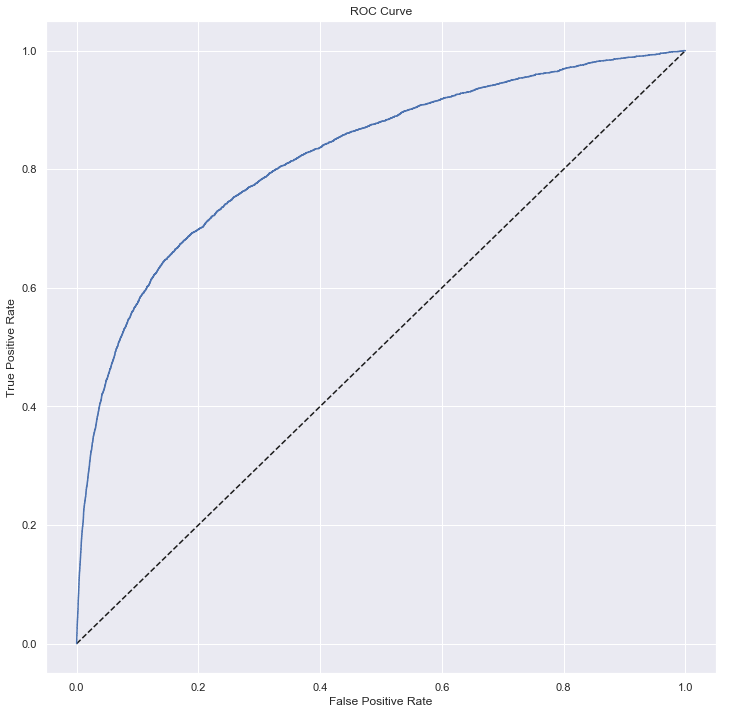

In [88]:
# ROC Curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


## Feature Selection (Lasso)

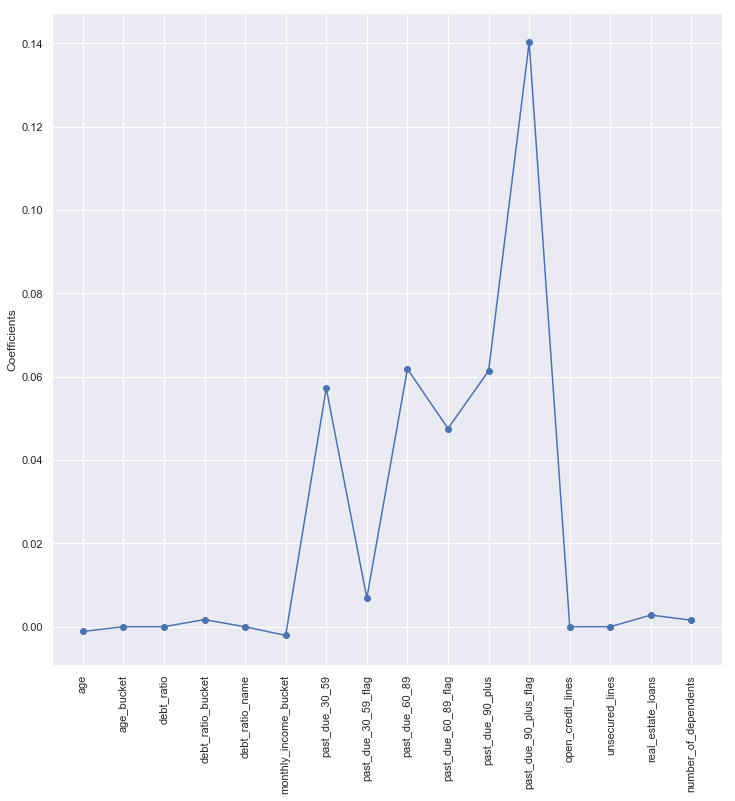

In [89]:
# Lasso

names = X.columns

lasso = Lasso(alpha=.001)
lasso_coef = lasso.fit(X_train, y_train).coef_

_ = plt.figure(figsize=(12,12))
_ = plt.plot(range(len(names)), lasso_coef, marker = 'o')
_ = plt.xticks(range(len(names)), names, rotation = 90)
_ = plt.ylabel('Coefficients')
plt.show()



In [90]:
# Lasso Training/Testing Scores

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)

lasso = Lasso(alpha=.01)
lasso.fit(X_train,y_train)
train_score=lasso.score(X_train,y_train)
test_score=lasso.score(X_test,y_test)
coeff_used = np.sum(lasso.coef_!=0)

print('Training Score:', train_score)
print('Test Score: ', test_score)
print('Number of features used: ', coeff_used)

Training Score: 0.14413396933823552
Test Score:  0.15082768108676092
Number of features used:  8
